In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import PIL
from PIL import Image

2.9.2


In [ ]:
! unzip '/content/drive/MyDrive/Flower_dataset.zip' -d '/content/drive/MyDrive/FDP_AdiSankara23/Flower_dataset/'

In [ ]:
imgFiles = glob.glob("/content/drive/MyDrive/FDP_AdiSankara23/Flower_dataset/tiny_FR/*/*.jpg") #navigate through sub-folders, parses them and store in a list
for items in imgFiles[:8]: #imgFiles is a list of strings, each string corresponds to the file path 
  print(items)

/content/drive/MyDrive/FDP_AdiSankara23/Flower_dataset/tiny_FR/daisy/102841525_bd6628ae3c.jpg
/content/drive/MyDrive/FDP_AdiSankara23/Flower_dataset/tiny_FR/daisy/100080576_f52e8ee070_n.jpg
/content/drive/MyDrive/FDP_AdiSankara23/Flower_dataset/tiny_FR/daisy/1031799732_e7f4008c03.jpg
/content/drive/MyDrive/FDP_AdiSankara23/Flower_dataset/tiny_FR/daisy/1150395827_6f94a5c6e4_n.jpg
/content/drive/MyDrive/FDP_AdiSankara23/Flower_dataset/tiny_FR/daisy/11642632_1e7627a2cc.jpg
/content/drive/MyDrive/FDP_AdiSankara23/Flower_dataset/tiny_FR/daisy/1140299375_3aa7024466.jpg
/content/drive/MyDrive/FDP_AdiSankara23/Flower_dataset/tiny_FR/daisy/107592979_aaa9cdfe78_m.jpg
/content/drive/MyDrive/FDP_AdiSankara23/Flower_dataset/tiny_FR/daisy/105806915_a9c13e2106_n.jpg


In [ ]:
print(len(imgFiles))

500


In [ ]:
X = []
y = []

for fName in imgFiles:
  
  # Prepare the dataset and populate X and y
  X_i = Image.open(fName) # /content/drive/MyDrive/FDP_AdiSankara23/Flower_dataset/tiny_FR/daisy/107592979_aaa9cdfe78_m.jpg
  X_i = X_i.resize((299,299)) 
  X_i = np.array(X_i) / 255.0 # Normalize to range 0.0 to 1.0 

  X.append(X_i)

  label = fName.split("/") # ['', 'content','drive', 'MyDrive', 'FDP_AdiSankara23','Flower_dataset','tiny_FR', 'daisy', '107592979_aaa9cdfe78_m.jpg']
  y_i = label[7] # 'sunflower'

  y.append(y_i)
    

#processed all  image files and corresponding intensity values and labels stored in X and y respectively 
#Note the labels are strings at this point 
    

In [ ]:
print(set(y))

{'rose', 'tulip', 'sunflower', 'dandelion', 'daisy'}


In [ ]:
from sklearn.preprocessing import LabelEncoder
lEncoder = LabelEncoder()
y = lEncoder.fit_transform(y)

print(set(y))
print(lEncoder.classes_)

{0, 1, 2, 3, 4}
['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']


In [ ]:
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(500, 299, 299, 3)
(500,)


## Split data into training and testing

In [ ]:
# Write code to split the data into 80% training and 20% testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

print("X_train_shape: {}".format(X_train.shape))
print("X_test_shape: {}".format(X_test.shape))

X_train_shape: (400, 299, 299, 3)
X_test_shape: (100, 299, 299, 3)


In [ ]:
mu = X_train.mean()
std = X_train.std()

X_train_std = (X_train-mu)/std
X_test_std = (X_test-mu)/std


## Construct the network

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)




In [ ]:
  #calculate any statistics required to  perform the transforms to your image data
datagen.fit(X_train_std)

In [ ]:
input_ = keras.layers.Input(shape = X_train.shape[1:])

x = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu')(input_)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units=1000, activation='relu')(x)

x = keras.layers.Dense(units=100, activation='relu')(x)


output_ = keras.layers.Dense(units=5, activation='softmax')(x)

model_CNN_augM = keras.models.Model(inputs=[input_], outputs=[output_])

model_CNN_augM.compile(loss='sparse_categorical_crossentropy', 
                       optimizer='adam', 
                       metrics=['accuracy'])

In [ ]:
# train the network
H = model_CNN_augM.fit_generator(datagen.flow(X_train_std, y_train, batch_size=32),
	validation_data=(X_test_std, y_test), steps_per_epoch=len(X_train) // 32,
	epochs=25)

In [ ]:
test_loss, test_accuracy = model_CNN_augM.evaluate(X_test_std, y_test)

print("Test-loss: %f, Test-accuracy: %f" % (test_loss, test_accuracy))

## Visualize the Sequential network


In [ ]:
keras.utils.plot_model(model_CNN_augM, "SequentialCNN.png", show_shapes=True)

## Non-sequential Networks

In [ ]:
# A simple ResNet type model

inputNS_ = keras.layers.Input(shape = (299,299,3))

x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(inputNS_)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
block_1_output = keras.layers.MaxPooling2D(2)(x)

x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(block_1_output)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
block_2_output = keras.layers.concatenate([x, block_1_output])

x = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(block_2_output)
x = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
block_3_output = keras.layers.concatenate([x, block_2_output])

x = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(block_3_output)
x = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
block_4_output = keras.layers.concatenate([x, block_3_output])

x = keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(block_4_output)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(100, activation="relu")(x) 


outputNS_ = keras.layers.Dense(units=5, activation='softmax')(x)

model_CNN_NS = keras.models.Model(inputs=[inputNS_], outputs=[outputNS_])



In [ ]:
model_CNN_NS.compile(loss='sparse_categorical_crossentropy', 
                       optimizer='adam', 
                       metrics=['accuracy'])

## Visualize the Non-Sequential network


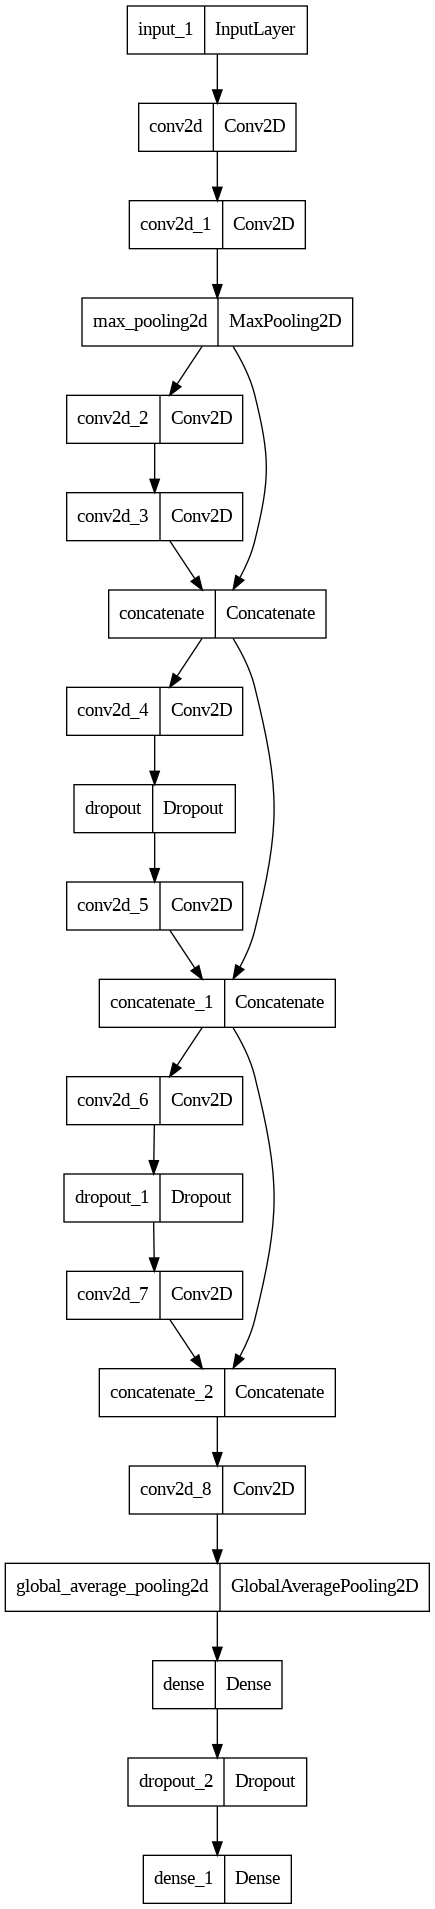

In [ ]:
keras.utils.plot_model(
    model_CNN_NS, 
    "NonSequential_CNN.png", 
    show_shapes=False
    )

## Training the network

In [ ]:
# train the network
H = model_CNN_NS.fit_generator(datagen.flow(X_train_std, y_train, batch_size=32),
	validation_data=(X_test_std, y_test), steps_per_epoch=len(X_train) // 32,   #// is floor division
	epochs=25)

In [ ]:
test_loss, test_accuracy = model_CNN_NS.evaluate(X_test_std, y_test)

print("Test-loss: %f, Test-accuracy: %f" % (test_loss, test_accuracy))